In [1]:
import os
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import random
from pathlib import Path
from pthflops import count_ops
from tqdm import tqdm

print(torch.__version__)
torch.manual_seed(42)
np.random.seed(seed=42)
random.seed(42)


2.0.1+cu118


### Things to track in table (using numpy): ###
Columns: epoch 1 PSNR, Num epochs/time to psnrs 20, 25, 30, 35, 
Rows: Frames 1, N

Columns: Time to  epochs/time to psnrs 20, 25, 30, 35
Rows: Frames 1, N

Columns: Num epochs/time to psnrs 20, 25, 30, 35
Rows: Frames 1, N


tensor([[[[0.0235, 0.0235, 0.0235],
          [0.0392, 0.0392, 0.0392],
          [0.0471, 0.0471, 0.0471],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000],
          [0.0078, 0.0078, 0.0078],
          [0.0157, 0.0157, 0.0157],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0078, 0.0078, 0.0078],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],

         ...,

         [[0.0039, 0.0039, 0.0039],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000

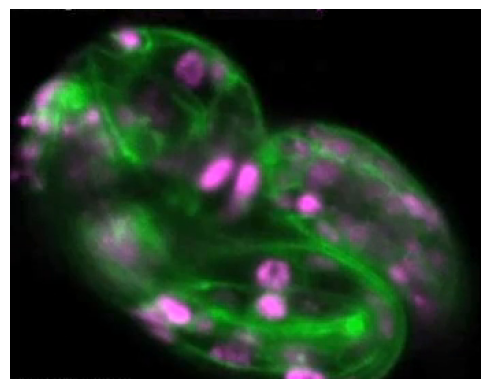

In [2]:
#Load video file - RUN ONCE
vRead = iio.imread('data/c_elegans.mp4')
video = np.array(vRead)
video = torch.as_tensor(video)
testFrame = video[0]
### Crop letters from video
def writeVideoMOV(videoTensor, filename='decoded'):

    w = iio.get_writer(filename + '.mov', format='FFMPEG', mode='I', fps=20,
                        codec='h264_vaapi',
                        output_params=['-vaapi_device',
                                        '/dev/dri/renderD128',
                                        '-vf',
                                        'format=gray|nv12,hwupload'],
                        pixelformat='vaapi_vld')
    for frame in videoTensor:
        w.append_data(frame.numpy())
    w.close()
    print('video saved in local directory as: ' + filename + '.mov')
    return None

croppedVideo = torch.zeros((2484, 270, 344,3)).type(torch.float32)
for i in range(len(video)):
    croppedVideo[i] = video[i][18:288]
#Normalize range of RGBs
croppedVideo = torch.mul(croppedVideo, 1.0/255.0).type(torch.float32)
plt.imshow(croppedVideo[100])
#writeVideoMOV(croppedVideo, filename="cropped_C_Elegans")
#Set Video to cropped version
plt.axis(False)
video = croppedVideo
print(video)

In [72]:
print("Cuda available: ", torch.cuda.is_available())
if(torch.cuda.is_available()):
    torch.cuda.set_device("cuda:0")

    print("Is cuDNN version:", torch.backends.cudnn.version())

    print("cuDNN enabled:a", torch.backends.cudnn.enabled)

    print("Device count: ", torch.cuda.device_count())

    print("Current device: ", torch.cuda.current_device())

    print("Device name: ", torch.cuda.get_device_name(torch.cuda.current_device()))
#Setup device agnostic code (i.e use GPU if possible)
device = "cuda" if torch.cuda.is_available() else "cpu"
gpuNum = 1
print(device)
video = video.to(device)

Cuda available:  True
Is cuDNN version: 8700
cuDNN enabled:a True
Device count:  3
Current device:  0
Device name:  NVIDIA RTX A6000
cuda


In [16]:
#Encoding
#INPUT  = L * F
#Output = 3
class hashNerf(nn.Module):
    def __init__(self,
                input_shape: int,
                hidden_units: int,
                output_shape: int,
                L=16, T=2**18, F=2, N_min=16, N_max=1024, num_output=3):
        self.L = L
        self.T = T
        self.F = F
        self.N_min = N_min
        self.N_max = N_max
        self.num_output = num_output
        super().__init__()
        b = np.exp((np.log(self.N_max) - np.log(self.N_min)) / (self.L - 1)) # scalar : dim 1
        self.N_values = torch.floor(torch.tensor(np.float32(self.N_min * b ** np.arange(self.L)))).type(torch.int64).to(device) # dim : 16,1
        temp_hash_table = torch.FloatTensor(L,T,F).uniform_(-1e-4, 1e-4) # dim : L, T, F
        self.hash_table = nn.Parameter(torch.tensor(temp_hash_table.clone(), requires_grad=True).to(device).type(torch.float32))
        self.vertices = torch.transpose(torch.tensor([
                        [0,0],
                        [0,1],
                        [1,0],
                        [1,1]]), 0,1).type(torch.float32).to(device) # dim : (2,4)
        self.prime_numbers = torch.tensor([1, 2654435761]).type(torch.int64).to(device)

        self.layer_stack = nn.Sequential(
            nn.Linear(input_shape, hidden_units),
            nn.LeakyReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.LeakyReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.LeakyReLU(),
            nn.Linear(hidden_units, output_shape),
            nn.ReLU()
        ).to(device)
    
    def forward(self, X):
        # X : 2D coordinates -> (num_points, 2)
        #print(self.hash_table)
        X = X.to(device)
        x_shape = X.shape
        x_scaled = X[:, :, None] * self.N_values[None, None, :]
        x_floor = torch.floor(x_scaled) # dim : (batch_size, 2, L)
        x_ceil = torch.ceil(x_scaled) # dim : (batch_size, 2, L)
        x_vertices = torch.zeros((len(x_floor), 2, self.L, 4)).to(device) # dim : (batch_size, 2, L, 4)
        x_vertices = x_floor[:, :, :, None] * self.vertices[None, :, None, :]
        x_vertices = x_vertices.type(torch.int64)
        
        primesTemp = torch.tensor([1, 2654435761]).type(torch.int64).to(device)
        x_to_hash_temp = x_vertices * primesTemp[None, :, None, None]

        x_hash_temp = torch.bitwise_xor(x_to_hash_temp[:, 0],
                                        x_to_hash_temp[:, 1]) # shape: num_points, L, 4
        x_hash_temp = torch.remainder(x_hash_temp, self.T) 
        x_hash = x_hash_temp
        x_hash = x_hash.to(device)
        #Tricky code
        x_hash = x_hash.permute(1, 0, 2)  # shape: L, num_points, 4

        lookup = torch.stack([self.hash_table[i][x_hash[i]] for i in range(self.L)], dim=0).to(device)
        #print('lookup shape:',lookup.shape)
        lookup = lookup.permute(1,0,2,3)  # shape: num_points, L, 4, F
        #print(lookup.shape)
        
        #interpolation
        weights = x_scaled - x_floor
        #print("weights:", weights)
        fx = weights[:, 0, :]
        cx = 1 - fx
        fy = weights[:, 1, :]
        cy = 1 - fy

        f11 = fx * fy
        f10 = fx * cy
        f01 = cx * fy
        f00 = cx * cy

        f_stack = torch.stack([f00, f01, f10, f11], dim=2).to(device)  # shape: num_points, L, 4
        #print(f_stack.shape)
        x_interp = torch.sum(f_stack[:, :, :, None] * lookup, dim=2)  # shape: num_points, L, F
        #print('x_interp shape:', x_interp.shape)
        x = x_interp.reshape(-1, self.L * self.F) # dim : num_points, L*F
        return self.layer_stack(x.to(device).type(torch.float32))


In [5]:
import os
from torch.utils.data import DataLoader
currFrame = 100
class SingleImageDataset(Dataset):
    def __init__(self, image, transform=None, target_transform=None):
        self.image = image.type(torch.float32)
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return int(self.image.shape[0]) * int(self.image.shape[1])
    def __getitem__(self, idx):
        row = idx // int(self.image.shape[1])
        col = idx % int(self.image.shape[1])
        pixel = torch.as_tensor(self.image[row][col]).type(torch.float32).to(device)
        #label = pixel 
        row = row / (workingFrame.shape[0]-1)
        col = col / (workingFrame.shape[1]-1)
        return torch.as_tensor([row, col]).type(torch.float32).to(device), pixel
workingFrame = video[currFrame]
training_data = SingleImageDataset(workingFrame)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/david_m/anaconda3/envs/pytorch/lib/python3.9/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


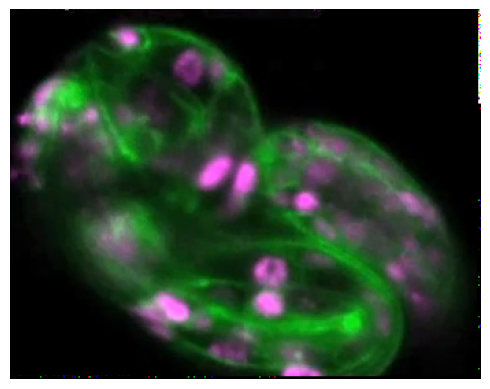

In [6]:
#DataLoader Sanity Check!
testGrid = torch.empty(video[currFrame].shape[0], video[currFrame].shape[1], 3).cpu()
testGrid = testGrid.type(torch.float32)
train_dataloader = DataLoader(training_data, batch_size=2, shuffle=True)
for batch in iter(train_dataloader):
    coords = batch[0].cpu()
    pixels = batch[1]
    for i in range(0, len(coords)):
        frameShape = workingFrame.shape
        row = int(coords[i][0] * (workingFrame.shape[0]-3))
        col = int(coords[i][1] * (workingFrame.shape[1]-3))
        # No normalization
     
        pixel = pixels[i]
        testGrid[row][col] = pixel
#testGrid = torch.mul(testGrid, 1)
plt.imshow(testGrid.cpu());
plt.axis(False);

In [7]:
##Utils
import math
def PSNR(MSELoss, max):
    return (20*math.log10(max)) - (10*math.log10(MSELoss))

In [8]:
from pathlib import Path
def saveModel(modelPointer, psnr_note=35, frameNumber=0):
    # 1. Create models directory - won't create if it exists
    MODEL_PATH = Path("c_elegans_models")
    MODEL_PATH.mkdir(parents=True, exist_ok=True)
    # 2. Create model save path
    MODEL_NAME = "hash_nerf_frame_"+frameNumber+"_psnr_"+str(psnr_note)+".pth"
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
    MODEL_SAVE_PATH
    #3. Save the model state dict
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=modelPointer.state_dict(),
            f=MODEL_SAVE_PATH)
    print(MODEL_SAVE_PATH)

In [60]:
#initialize model
model_0 = hashNerf(32, 128, 3)

/tmp/ipykernel_7827/516394135.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.hash_table = nn.Parameter(torch.tensor(temp_hash_table.clone(), requires_grad=True).to(device).type(torch.float32))


In [61]:
lr1 = 0.01
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=lr1, eps=10e-15)

In [62]:
# Training
from tqdm import tqdm
PSNR_thresh = 39.00
train_loader = DataLoader(training_data, batch_size=2**14, shuffle=True)
batchCount = 0
psnr_table = []
savedAt25 = False
savedAt30 = False
exit_loop = False
for epoch in tqdm(range(0,50)):
    model_0.train()
    for batch in iter(train_loader):
        batchCount += 1
        y_train = torch.as_tensor(batch[1]).to(device)
        y_train = torch.squeeze(y_train)
        X = torch.tensor(batch[0]).type(torch.float32)
        y_train = torch.as_tensor(y_train).type(torch.float32)
        # Forward Pass
        y_pred = model_0(X).to(device).type(torch.float32)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    psnr = PSNR(loss, 1.0)
    psnr_table.append(psnr)
    if (savedAt25 == False) and (psnr >= 25):
        #saveModel(model_0, 25, 0)
        savedAt25 = True
    elif (savedAt30 == False) and (psnr >= 30):
        lr1 = lr1/10
        #saveModel(model_0, 30, 0)
        savedAt30 = True
    elif (psnr >= PSNR_thresh):
        break
    if epoch % 1 == 0:
        print(f"Epoch: {epoch} | LR: {lr1} | Train loss: {loss} | PSNR: {psnr}")
    """
    if epoch == 10:
        lr1 = lr1/10
    if epoch == 20:
        lr1 = lr1/2
    """
print('Training Finished')

  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_7827/828744789.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch[0]).type(torch.float32)
  2%|▏         | 1/50 [00:11<09:00, 11.03s/it]

Epoch: 0 | LR: 0.01 | Train loss: 0.027997029945254326 | PSNR: 15.528880381864491


  4%|▍         | 2/50 [00:22<08:53, 11.12s/it]

Epoch: 1 | LR: 0.01 | Train loss: 0.016291070729494095 | PSNR: 17.880503707787145


  6%|▌         | 3/50 [00:29<07:12,  9.19s/it]

Epoch: 2 | LR: 0.01 | Train loss: 0.009601893834769726 | PSNR: 20.176431002027805


  8%|▊         | 4/50 [00:39<07:25,  9.69s/it]

Epoch: 3 | LR: 0.01 | Train loss: 0.005017568822950125 | PSNR: 22.995066618454633


 10%|█         | 5/50 [00:48<07:11,  9.58s/it]

Epoch: 4 | LR: 0.01 | Train loss: 0.003298393217846751 | PSNR: 24.816975712017136


 12%|█▏        | 6/50 [00:59<07:20, 10.02s/it]

Epoch: 5 | LR: 0.01 | Train loss: 0.0020362073555588722 | PSNR: 26.911779980496217


 14%|█▍        | 7/50 [01:10<07:16, 10.14s/it]

Epoch: 6 | LR: 0.01 | Train loss: 0.0014438972575590014 | PSNR: 28.40463708471823


 16%|█▌        | 8/50 [01:19<06:55,  9.90s/it]

Epoch: 7 | LR: 0.001 | Train loss: 0.0008760737255215645 | PSNR: 30.574593444713038


 18%|█▊        | 9/50 [01:30<06:53, 10.09s/it]

Epoch: 8 | LR: 0.001 | Train loss: 0.0007152441539801657 | PSNR: 31.455456831969826


 20%|██        | 10/50 [01:37<06:10,  9.27s/it]

Epoch: 9 | LR: 0.001 | Train loss: 0.0005639552837237716 | PSNR: 32.48755330062595


 22%|██▏       | 11/50 [01:45<05:45,  8.87s/it]

Epoch: 10 | LR: 0.001 | Train loss: 0.00041240290738642216 | PSNR: 33.846782816585765


 24%|██▍       | 12/50 [01:55<05:51,  9.25s/it]

Epoch: 11 | LR: 0.001 | Train loss: 0.0002925191365648061 | PSNR: 35.338457171625095


 26%|██▌       | 13/50 [02:04<05:43,  9.29s/it]

Epoch: 12 | LR: 0.001 | Train loss: 0.0002785393735393882 | PSNR: 35.55113405509107


 28%|██▊       | 14/50 [02:15<05:47,  9.66s/it]

Epoch: 13 | LR: 0.001 | Train loss: 0.00025337893748655915 | PSNR: 35.96229489348177


 30%|███       | 15/50 [02:25<05:45,  9.86s/it]

Epoch: 14 | LR: 0.001 | Train loss: 0.00021542541799135506 | PSNR: 36.66703055717133


 32%|███▏      | 16/50 [02:35<05:33,  9.81s/it]

Epoch: 15 | LR: 0.001 | Train loss: 0.000226061005378142 | PSNR: 36.45774345260283


 34%|███▍      | 17/50 [02:45<05:28,  9.96s/it]

Epoch: 16 | LR: 0.001 | Train loss: 0.00017397884221281856 | PSNR: 37.59503563607773


 36%|███▌      | 18/50 [02:51<04:40,  8.76s/it]

Epoch: 17 | LR: 0.001 | Train loss: 0.00018337230721954256 | PSNR: 37.36666250617128


 38%|███▊      | 19/50 [03:01<04:39,  9.02s/it]

Epoch: 18 | LR: 0.001 | Train loss: 0.00014924666902516037 | PSNR: 38.260953529298185


 40%|████      | 20/50 [03:11<04:43,  9.44s/it]

Epoch: 19 | LR: 0.001 | Train loss: 0.00019473842985462397 | PSNR: 37.105483359638


 42%|████▏     | 21/50 [03:21<04:32,  9.39s/it]

Epoch: 20 | LR: 0.001 | Train loss: 0.0001804441853892058 | PSNR: 37.436571080299025


 44%|████▍     | 22/50 [03:31<04:29,  9.64s/it]

Epoch: 21 | LR: 0.001 | Train loss: 0.00021787518926430494 | PSNR: 36.617922226178884


 46%|████▌     | 23/50 [03:40<04:19,  9.59s/it]

Epoch: 22 | LR: 0.001 | Train loss: 0.00016727065667510033 | PSNR: 37.7658023812781


 48%|████▊     | 24/50 [03:50<04:13,  9.75s/it]

Epoch: 23 | LR: 0.001 | Train loss: 0.00011908551095984876 | PSNR: 39.241410755698894


 50%|█████     | 25/50 [04:00<04:02,  9.71s/it]

Epoch: 24 | LR: 0.001 | Train loss: 0.00017172757361549884 | PSNR: 37.65159966297376


 52%|█████▏    | 26/50 [04:07<03:34,  8.94s/it]

Epoch: 25 | LR: 0.001 | Train loss: 0.0001693181984592229 | PSNR: 37.7129636105428


 54%|█████▍    | 27/50 [04:18<03:36,  9.42s/it]

Epoch: 26 | LR: 0.001 | Train loss: 0.00013990415027365088 | PSNR: 38.54169401918395


 56%|█████▌    | 28/50 [04:27<03:27,  9.43s/it]

Epoch: 27 | LR: 0.001 | Train loss: 0.00011357094626873732 | PSNR: 39.44732755675894


 58%|█████▊    | 29/50 [04:40<03:36, 10.30s/it]

Epoch: 28 | LR: 0.001 | Train loss: 0.0001248746702913195 | PSNR: 39.035256454394315


 60%|██████    | 30/50 [04:51<03:32, 10.63s/it]

Epoch: 29 | LR: 0.001 | Train loss: 0.00012278658687137067 | PSNR: 39.108490726566615


 62%|██████▏   | 31/50 [05:02<03:22, 10.63s/it]

Epoch: 30 | LR: 0.001 | Train loss: 0.00014835952606517822 | PSNR: 38.28684562695858


 64%|██████▍   | 32/50 [05:13<03:17, 10.97s/it]

Epoch: 31 | LR: 0.001 | Train loss: 0.00015055832045618445 | PSNR: 38.22295238634404


 66%|██████▌   | 33/50 [05:20<02:45,  9.71s/it]

Epoch: 32 | LR: 0.001 | Train loss: 0.00020551763009279966 | PSNR: 36.871509167387615


 68%|██████▊   | 34/50 [05:31<02:41, 10.11s/it]

Epoch: 33 | LR: 0.001 | Train loss: 0.0001483639352954924 | PSNR: 38.28671655698978


 68%|██████▊   | 34/50 [05:36<02:38,  9.88s/it]


KeyboardInterrupt: 

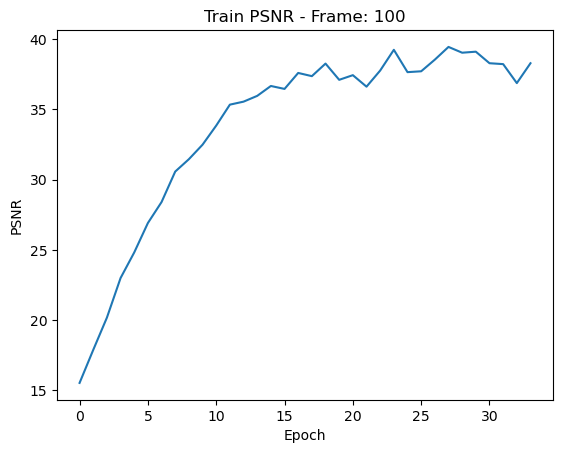

In [70]:
#Plot PSNR
plt.plot(range(0,len(psnr_table)), psnr_table)
plt.title('Train PSNR - Frame: '+str(currFrame))
plt.ylabel('PSNR')
#NOT EPOCHS - THESE ARE BATCHES!!!
plt.xlabel('Epoch')
plt.savefig("c_elegans_psnr_plots/hash_nerf_reconstruction_frame_"+str(currFrame)+".png", bbox_inches="tight")
plt.show()


In [ ]:
for name, param in model_0.named_parameters():
    if param.requires_grad:
        print(name)

hash_table
layer_stack.0.weight
layer_stack.0.bias
layer_stack.2.weight
layer_stack.2.bias
layer_stack.4.weight
layer_stack.4.bias
layer_stack.6.weight
layer_stack.6.bias


In [ ]:
for p in model_0.parameters():
    print(p.shape)

torch.Size([16, 262144, 2])
torch.Size([256, 32])
torch.Size([256])
torch.Size([256, 256])
torch.Size([256])
torch.Size([256, 256])
torch.Size([256])
torch.Size([3, 256])
torch.Size([3])


In [24]:
model_0.eval()
x_test_T = torch.as_tensor(croppedVideo[100])
reconstruction_input_matrix = torch.zeros(croppedVideo[100].shape[0], croppedVideo[100].shape[1], 2).type(torch.float32)
#encode coordinates into debug matrix
for i in range(0, x_test_T.shape[0]):
    for j in range(0, x_test_T.shape[1]):
        reconstruction_input_matrix[i][j] = torch.as_tensor([i/(workingFrame.shape[0]-1.0),j/(workingFrame.shape[1]-1.0)]).type(torch.float32)
reconstruction_input_matrix = torch.flatten(reconstruction_input_matrix, 0, 1)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


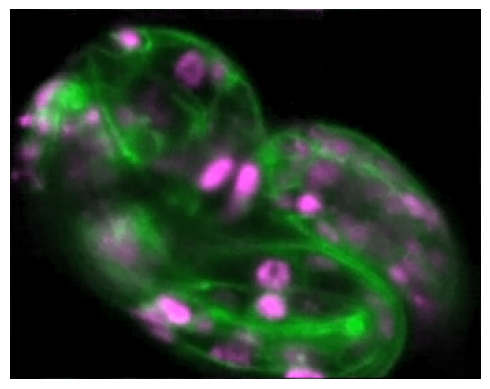

In [59]:
im_psnr_note = 40
model_0.eval()
with torch.inference_mode():
    reconstruction = model_0(reconstruction_input_matrix).cpu()
    reconstruction = reconstruction.reshape((croppedVideo[100].shape[0], croppedVideo[100].shape[1],3))
    reconstruction = torch.mul(reconstruction, 255.0).type(torch.int32)
    plt.imshow(reconstruction)
    plt.axis(False)
    #plt.title("HashNerf - PSNR:"+ str(round(psnr_table[-1], 4)))
    plt.savefig("c_elegans_reconstructions/hash_nerf_reconstruction_frame_"+str(currFrame)+"_psnr_"+str(im_psnr_note)+".png", bbox_inches="tight", pad_inches=0.0)
    #save
    

In [ ]:
b = np.exp((np.log(512) - np.log(16)) / (16 - 1))
#print(b)
a = np.float32(16 * b ** np.arange(16))
a = torch.floor(torch.tensor(a).type(torch.float32)).to(device)
#print(a.shape)
#print(a)
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
tempX = torch.tensor([[1,1],
                      [1,2],
                      [2,4],
                      [10,2],
                      [2.1, 10.1],
                      [0,1.01],
                      [10,2],
                      [2.1, 10.1],
                      [0,1],
                      [10,2],
                      [2.1, 10.1],
                      [0,1],
                      [10,2],
                      [2.1, 10.1],
                      [0,1],
                      [10,2],
                      [2.1, 10.1],
                      [0,1],
                      [2.1, 10.1],
                      [0,1],
                      [2.1, 10.1],
                      [0,1],
                      [2.1, 10.1],
                      [1,1]
                      ])
for batch in iter(train_dataloader):
    tempX = batch[0]
    print('batch')
    #print(tempX)
    print(tempX.shape)
    break
tempX1 = tempX[:,[0]]
tempX2 = tempX[:,[1]]
tempX1 = tempX1 * a
tempX2 = tempX2 * a
#print(tempX1.shape)
#print(tempX2.shape)
tempConstruct = torch.hstack((tempX1, tempX2))
#print(tempX)
#print(tempConstruct)
outputT = torch.zeros((len(tempX), 2, 16)).type(torch.float32)
for i in range(len(tempX1)):
    outputT[i][0] = tempX[i][0] * a
    outputT[i][1] = tempX[i][1] * a

x_scaled_temp  = outputT

#print(outputT)
print(outputT.shape)

verts = torch.transpose(torch.tensor([
                        [0,0],
                        [1,0],
                        [0,1],
                        [1,1]]), 0,1).type(torch.float32) # dim : (2,4)

outputVertices = torch.zeros((len(outputT), 2, 16, 4))
for i in range(len(outputT)):
    # make sure to do x and y !
    for j in range(0,16):
        outputVertices[i][0][j] = outputT[i][0][j] * verts[0]
        outputVertices[i][1][j] = outputT[i][1][j] * verts[1]
outputVertices = torch.floor(outputVertices).type(torch.int64)
#print(outputVertices)
print(outputVertices.shape)
primesTemp = torch.tensor([2654435761, 1]).type(torch.int64)
x_to_hash_temp = outputVertices * primesTemp[None, :, None, None]
#print(x_to_hash_temp)
print(x_to_hash_temp.shape)

x_hash_temp = torch.bitwise_xor(x_to_hash_temp[:, 0],
                                  x_to_hash_temp[:, 1]) # shape: num_points, L, 4
x_hash_temp = torch.remainder(x_hash_temp, 2) 

#### Begin sketchy code

debug_hash_table = torch.FloatTensor(16, 2**18, 2).uniform_(-1e-4, 1e-4)
print(x_hash_temp.shape)
x_hash_temp = x_hash_temp.permute(1, 0, 2)  # shape: L, num_points, 4
print('hash table shape:', debug_hash_table.shape)
print('x_hash shape:', x_hash_temp.shape)
"""
# lookup hash table:
def gather(a):
    return torch.gather(a[0], 0, a[1].unsqueeze(2).expand(-1, -1, 2))

lookup = torch.stack([gather((debug_hash_table, x_hash_temp[i])) for i in range(16)], dim=0) # shape: L, numPoints , 4, 2
print(lookup.shape)
lookup = lookup.permute(1,0,2,3)  # shape: num_points, L, 4, F
"""
gather = lambda a: torch.gather(a[0], 1, a[1].unsqueeze(2).expand(-1, -1, a[0].size(2)))
lookup = torch.stack([gather((debug_hash_table, x_hash_temp[:, i])) for i in range(x_hash_temp.size(1))], dim=1)
lookup = lookup.permute(1, 0, 2, 3)  # shape: num_points, L, 16, F

print('lookup shape:', lookup.shape)
#interpolation
weights_temp =  outputT - torch.floor(outputT)
print('weights:', weights_temp)

fx = weights_temp[:, 0, :]
cx = 1 - fx
fy = weights_temp[:, 1, :]
cy = 1 - fy
f11 = fx * fy
f10 = fx * cy
f01 = cx * fy
f00 = cx * cy

f_stack_temp = torch.stack([f00, f01, f10, f11], dim=2)  # shape: num_points, L, 4
print(f_stack_temp.shape)
x_interp = torch.sum(f_stack_temp[:, :, :, None] * lookup, dim=2)  # shape: num_points, L, F
print(x_interp.shape)
x = x_interp.reshape(-1, 16*2) # dim : num_points, L*F
print(x.shape)

batch
torch.Size([32, 2])
torch.Size([32, 2, 16])
torch.Size([32, 2, 16, 4])
torch.Size([32, 2, 16, 4])
torch.Size([32, 16, 4])
hash table shape: torch.Size([16, 262144, 2])
x_hash shape: torch.Size([16, 32, 4])
lookup shape: torch.Size([32, 16, 4, 2])
weights: tensor([[[0.9333, 0.6667, 0.8333,  ..., 0.5333, 0.9333, 0.8667],
         [0.7674, 0.7093, 0.6366,  ..., 0.3198, 0.0988, 0.5581]],

        [[0.1407, 0.9259, 0.4074,  ..., 0.2074, 0.6963, 0.5037],
         [0.4419, 0.3023, 0.1279,  ..., 0.7674, 0.8372, 0.1395]],

        [[0.8741, 0.5926, 0.7407,  ..., 0.3407, 0.4296, 0.9704],
         [0.9535, 0.9419, 0.6773,  ..., 0.5639, 0.3198, 0.5116]],

        ...,

        [[0.8000, 0.0000, 0.0000,  ..., 0.6000, 0.8000, 0.6000],
         [0.0000, 0.0000, 0.5000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1407, 0.9259, 0.9074,  ..., 0.2074, 0.6963, 0.5037],
         [0.7674, 0.2093, 0.7616,  ..., 0.5698, 0.8488, 0.5581]],

        [[0.7111, 0.8889, 0.1111,  ..., 0.3111, 0.0444, 0.7556],

In [ ]:
L=16
T=2**18
F=2
N_min=16
N_max=512
temp = torch.FloatTensor(L, T,F).uniform_(-1e-4, 1e-4)
print(temp)
print(temp.shape)


tensor([[[ 5.9389e-05, -5.5447e-05],
         [-1.1209e-05,  6.1000e-05],
         [-6.9846e-05, -8.2321e-05],
         ...,
         [-5.3848e-05,  2.4687e-05],
         [ 3.0202e-05,  7.6156e-05],
         [ 8.4700e-05,  4.6343e-05]],

        [[ 2.7111e-05, -9.0096e-05],
         [-9.2029e-06,  6.3181e-05],
         [-5.7037e-05, -2.1538e-05],
         ...,
         [-2.4205e-05, -7.6291e-06],
         [-1.5806e-05,  1.2426e-05],
         [-2.5164e-05,  5.3561e-05]],

        [[ 2.2662e-05, -2.4646e-05],
         [ 8.4154e-05, -7.5529e-06],
         [-9.0923e-05,  1.0564e-05],
         ...,
         [ 7.3005e-05, -5.4923e-06],
         [-8.6069e-05,  9.4029e-05],
         [ 8.7870e-05, -4.2551e-05]],

        ...,

        [[ 9.2899e-05,  7.7094e-05],
         [-5.2735e-05, -6.6905e-06],
         [-5.7840e-05, -3.4860e-05],
         ...,
         [ 2.2099e-05,  8.6120e-06],
         [-6.1649e-05,  1.4428e-05],
         [-1.1014e-05,  2.4512e-05]],

        [[ 5.8661e-05,  1.2266e-05

In [ ]:
a_temp = torch.transpose(torch.tensor([
                        [0,0],
                        [1,0],
                        [0,1],
                        [1,1]]), 0,1).type(torch.float32)
print(a_temp[0])

tensor([0., 1., 0., 1.])


In [ ]:
quit()

: 